In [1]:
from transformers.cache_utils import DynamicCache
from transformers import LlamaForCausalLM, AutoConfig
from tqdm import tqdm
import torch
import time

In [2]:
model = LlamaForCausalLM.from_pretrained(
    'mesolitica/malaysian-tinyllama-1.1b-16k-instructions-v4',
                                        torch_dtype = torch.bfloat16).cuda()

In [3]:
input_ids = torch.tensor([5] * 30000).unsqueeze(0).cuda()

In [4]:
cache = DynamicCache()

In [5]:
memory_allocated, time_taken = [], []
with torch.no_grad():
    with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_mem_efficient=False, enable_math=True):
        for i in tqdm(range(1000)):
            logits = model.forward(input_ids, past_key_values = cache, use_cache = True).logits
            input_ids = logits.argmax(-1)[:, -1:]
            del logits
            memory_allocated.append(torch.cuda.memory_allocated())
            time_taken.append(time.time())

/home/husein/.local/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.39it/s]


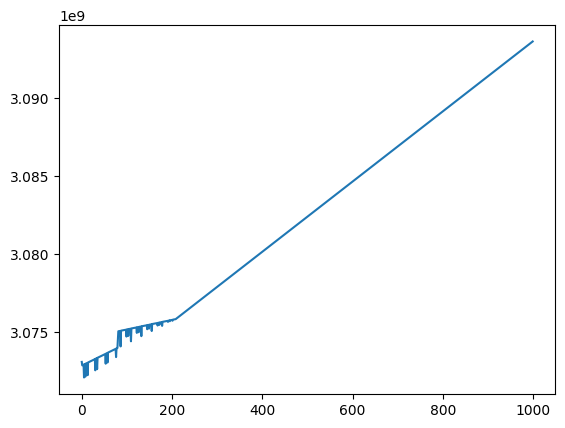

In [6]:
import matplotlib.pyplot as plt

plt.plot(memory_allocated)

In [8]:
import json

with open('llama-1.1b-30k.json', 'w') as fopen:
    json.dump({
        'memory_allocated': memory_allocated,
        'time_taken': time_taken,
    }, fopen)